# Tutorial 02 - Loading and Visualizing Exported Surface Data

In this tutorial we will look at how to load surface data that was exported from Pupil Player into Python to generate aggregate heatmaps. We will follow these steps:

0. Load a reference image.
1. Load the data using `Pandas`
2. Visualize gaze data for 1 surface for 1 participant as a heatmap.
3. Visualize gaze data for 1 surface for multiple participants as a heatmap.

## 0 - Loading libraries and reference image

In this example, participants were asked to look at the cover of a magazine. We can quickly load the reference image (either from a file or from a url as in the example below):

In [1]:
import numpy as np
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
import urllib

user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/535.19 (KHTML, like Gecko) Ubuntu/12.04 Chromium/18.0.1025.168 Chrome/18.0.1025.168 Safari/535.19'
url = "https://cdn.technologyreview.com/i/images/mag.coverx1004_2.jpg?sw=400"
magazine_cover_ref_file = urllib.request.urlopen(urllib.request.Request(url, headers={'User-Agent': user_agent}))
magazine_cover_ref_image = np.fliplr(rotate(plt.imread(magazine_cover_ref_file, format='jpg'), 180))

## 1 - Loading Exported Surface Data

Now lets see how to load the exported gaze data for this surface. The file will be named with the pattern `gaze_positions_on_surface_<your-surface-name>_<uid>.csv`

In [2]:
import os
import pandas as pd

recordings_location = '/home/pupil-labs/recordings'
demo_recording = '2019_02_14/003'
file_name = 'gaze_positions_on_surface_magazine_cover_1550027153.7953088.csv'
exported_surface_csv = os.path.join(recordings_location, demo_recording, 
                                    'exports', '000', 'surfaces', file_name)
surface_pd_frame = pd.read_csv(exported_surface_csv)

print("Columns present in exported gaze on surface data:\n {}".format(surface_pd_frame.columns))

Columns present in exported gaze on surface data:
 Index(['world_timestamp', 'world_frame_idx', 'gaze_timestamp', 'x_norm',
       'y_norm', 'x_scaled', 'y_scaled', 'on_srf', 'confidence'],
      dtype='object')


### Individual Datums

As we can see the data frame contains only a few columns. Let's review what each column is used for:

- `world_timestamp` - The world camera timestamp at which the sample was recorded.
- `world_frame_idx` - The frame number of the world camera to which this sample is correlated.
- `gaze_timestamp` - The timestamp of the gaze position which is correlated with this world frame (note that there can be many gaze positions per world frame due to higher sampling rate of eye cameras relative to world cameras)
- `x_norm` - the normalized x position of the gaze relative to the surface. (0,0) is the bottom left corner of the surface; (1,1) is the top right corner of the surface. Note that coordinates outside of the 0-1 bounds are possible which means that the gaze is **not** on the surface. 
- `y_norm` - the normalized y position of the gaze relative to the surface.
- `x_scaled` and `y_scaled` - the position of the gaze relative to the surface scaled relative to the specified size of the surface. The size is defined in Pupil Player or Pupil Capture. 
- `on_srf` - boolean value if gaze is within the bounds of the surface
- `confidence` - confidence of the pupil detection

Let's take a look at a few values from our sample surface data!


In [3]:
gaze_on_srf = surface_pd_frame[surface_pd_frame.on_srf == True]
pd.options.display.float_format = '{:.3f}'.format

headers = surface_pd_frame.columns
print("gaze on (magazine surface) data:\n {}".format(gaze_on_srf[headers][:5]))

gaze on (magazine surface) data:
    world_timestamp  world_frame_idx  gaze_timestamp  x_norm  y_norm  x_scaled  \
0       279527.233                0      279527.197   0.928   0.909   371.082   
1       279527.233                0      279527.199   0.928   0.909   371.354   
2       279527.233                0      279527.202   0.929   0.908   371.457   
3       279527.233                0      279527.204   0.925   0.906   370.110   
4       279527.233                0      279527.207   0.926   0.905   370.437   

   y_scaled  on_srf  confidence  
0   454.289    True       0.999  
1   454.663    True       0.999  
2   453.774    True       0.999  
3   453.088    True       0.999  
4   452.707    True       1.000  


We could take this example further by filtering out low `confidence` pupil detection values:

In [4]:
gaze_on_srf = surface_pd_frame[(surface_pd_frame.on_srf == True) & (surface_pd_frame.confidence > 0.8)]
pd.options.display.float_format = '{:.3f}'.format

headers = surface_pd_frame.columns
print("gaze on (magazine surface) data:\n {}".format(gaze_on_srf[headers][:5]))

gaze on (magazine surface) data:
    world_timestamp  world_frame_idx  gaze_timestamp  x_norm  y_norm  x_scaled  \
0       279527.233                0      279527.197   0.928   0.909   371.082   
1       279527.233                0      279527.199   0.928   0.909   371.354   
2       279527.233                0      279527.202   0.929   0.908   371.457   
3       279527.233                0      279527.204   0.925   0.906   370.110   
4       279527.233                0      279527.207   0.926   0.905   370.437   

   y_scaled  on_srf  confidence  
0   454.289    True       0.999  
1   454.663    True       0.999  
2   453.774    True       0.999  
3   453.088    True       0.999  
4   452.707    True       1.000  


## 2 - Visualize aggregate gaze on surface for single participant

Now we visualize high confidence gaze data on this surface.

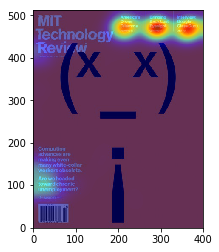

In [5]:
from scipy.ndimage.filters import gaussian_filter

grid = (512,400) # this should match the real world size of the image
heatmap_detail = 0.04 

gaze_x_scaled = gaze_on_srf['x_norm']
gaze_y_scaled = gaze_on_srf['y_norm']

hist, x_edges, y_edges = np.histogram2d(
            gaze_y_scaled, gaze_x_scaled, range=[[0, 1.0], [0, 1.0]], normed=False, bins=grid)
filter_h = int(heatmap_detail * grid[0]) // 2 * 2 + 1
filter_w = int(heatmap_detail * grid[1]) // 2 * 2 + 1
hist_max = hist.max()
hist *= (255.0 / hist_max) if hist_max else 0.0

ref_image = plt.imshow(magazine_cover_ref_image, interpolation=None)

single_heatmap = plt.imshow(gaussian_filter(hist, sigma=(filter_w, filter_h), order=0), 
           interpolation=None, shape=grid, origin='lower', cmap='jet', alpha=0.6)


plt.show()

## 3 - Visualize aggregate gaze on surface for multiple participants

We will now repeat steps 1 and 2 from above but will load the same `surface` from multiple recordings. This could be considered as an example of how to make an aggregate heatmap for multiple participants in a single study.


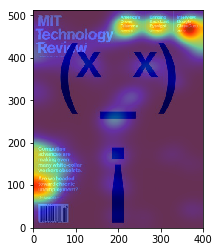

In [6]:
from glob import glob

demo_recordings_path = '2019_02_14'
surface_path_pattern = '**/exports/**/surfaces/gaze_positions_on_surface_magazine_cover_*.csv'
surface_files = glob(os.path.join(recordings_location, demo_recordings_path, surface_path_pattern), 
                     recursive=True)

surface_pd_frames = pd.DataFrame()
for fp in surface_files:
    frame = pd.read_csv(fp)
    
    surface_pd_frames = surface_pd_frames.append(frame)
    
gaze_on_surfaces = surface_pd_frames[(surface_pd_frames.on_srf == True) & (surface_pd_frames.confidence > 0.8)]    
gaze_x_scaled = gaze_on_surfaces['x_norm']
gaze_y_scaled = gaze_on_surfaces['y_norm']

hist, x_edges, y_edges = np.histogram2d(
            gaze_y_scaled, gaze_x_scaled, range=[[0, 1.0], [0, 1.0]], normed=False, bins=grid)
filter_h = int(heatmap_detail * grid[0]) // 2 * 2 + 1
filter_w = int(heatmap_detail * grid[1]) // 2 * 2 + 1
hist_max = hist.max()
hist *= (255.0 / hist_max) if hist_max else 0.0

ref_image = plt.imshow(magazine_cover_ref_image, interpolation=None)

aggregate_heatmap = plt.imshow(gaussian_filter(hist, sigma=(filter_w, filter_h), order=0), 
           interpolation=None, shape=grid, origin='lower', cmap='jet', alpha=0.6)

plt.show()
